<a href="https://colab.research.google.com/github/reda-maizate/monuments-recognition/blob/master/monuments_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy
from fastai import *
from fastai.vision import *
import shutil

In [3]:
# !mkdir ./temp
# !git clone "https://b99ffaa93c7354d8aeda754569061124471e4ede@github.com/reda-maizate/monuments-recognition.git" ./temp
# !rsync -aP --exclude=data/ '/content'/* ./temp

Cloning into './temp'...
remote: Enumerating objects: 5495, done.
remote: Counting objects: 100% (5495/5495), done.
remote: Compressing objects: 100% (5494/5494), done.
remote: Total 5495 (delta 0), reused 5495 (delta 0), pack-reused 0
Receiving objects: 100% (5495/5495), 54.64 MiB | 20.46 MiB/s, done.


In [4]:
data_dir = '/content/temp/paris-monuments'

In [5]:
classes = os.listdir(data_dir)
total = 0

for name in classes:
  print(name, ':', len(os.listdir(data_dir+'/'+name)))
  total += len(os.listdir(data_dir+'/'+name))

print("Number total of images:", total)

pont-neuf : 748
musee-d-orsay : 679
place-de-la-concorde : 718
jardin-des-tuileries : 654
arc-de-triomphe : 732
palais-de-l-elysee : 702
moulin-rouge : 652
hotel-de-ville : 620
Number total of images: 5505


In [6]:
%cd temp/

/content/temp


In [7]:
# Make a parent directory `data` and two sub directories `train`, `valid` and `test`
%mkdir -p data/train
%mkdir -p data/valid
%mkdir -p data/test

# Inside the train and validation sub-directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/jardin-des-tuileries
%mkdir -p train/pont-neuf
%mkdir -p train/place-de-la-concorde
%mkdir -p train/moulin-rouge
%mkdir -p train/musee-d-orsay
%mkdir -p train/arc-de-triomphe
%mkdir -p train/palais-de-l-elysee
%mkdir -p train/hotel-de-ville

%mkdir -p valid/jardin-des-tuileries
%mkdir -p valid/pont-neuf
%mkdir -p valid/place-de-la-concorde
%mkdir -p valid/moulin-rouge
%mkdir -p valid/musee-d-orsay
%mkdir -p valid/arc-de-triomphe
%mkdir -p valid/palais-de-l-elysee
%mkdir -p valid/hotel-de-ville

%cd ..

/content/temp/data
/content/temp


In [8]:
monuments = []

for i in classes:
    # Get all the file names
    all_monuments = os.listdir(data_dir+'/'+i)
    # Add them to the list
    for monument in all_monuments:
        monuments.append((i, str(data_dir+'/'+i) + '/' + monument))

# Build a dataframe        
monuments_df = pd.DataFrame(data=monuments, columns=['category', 'image'], index=None)

In [9]:
monuments_df.head()

,category,image
0,pont-neuf,/content/temp/paris-monuments/pont-neuf/images...
1,pont-neuf,/content/temp/paris-monuments/pont-neuf/images...
2,pont-neuf,/content/temp/paris-monuments/pont-neuf/images...
3,pont-neuf,/content/temp/paris-monuments/pont-neuf/images...
4,pont-neuf,/content/temp/paris-monuments/pont-neuf/images...


In [10]:
mn_count = monuments_df['category'].value_counts()
mn_count

pont-neuf               748
arc-de-triomphe         732
place-de-la-concorde    718
palais-de-l-elysee      702
musee-d-orsay           679
jardin-des-tuileries    654
moulin-rouge            652
hotel-de-ville          620
Name: category, dtype: int64

In [11]:
len_test = 130

for category in mn_count.index:
    samples = monuments_df['image'][monuments_df['category'] == category].values
    perm = np.random.permutation(samples)

    for i in range(len_test):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/test/' + str(category) + '_' + name)
    
    for i in range(len_test+1, len_test*2):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/valid/' + str(category) + '/'+ name)

    for i in range((len_test*2)+1,len(perm)):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/train/' + str(category) + '/' + name)

In [12]:
DATA_PATH = Path('/content/temp/data/')
BATCH_SIZE = 64

In [13]:
data = ImageDataBunch.from_folder(path=DATA_PATH,
                                  train='train',
                                  valid='valid',
                                  ds_tfms=get_transforms(flip_vert=False),
                                  size=224,
                                  bs=BATCH_SIZE
                                  )

In [14]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (3417 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pont-neuf,pont-neuf,pont-neuf,pont-neuf,pont-neuf
Path: /content/temp/data;

Valid: LabelList (1032 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pont-neuf,pont-neuf,pont-neuf,pont-neuf,pont-neuf
Path: /content/temp/data;

Test: None

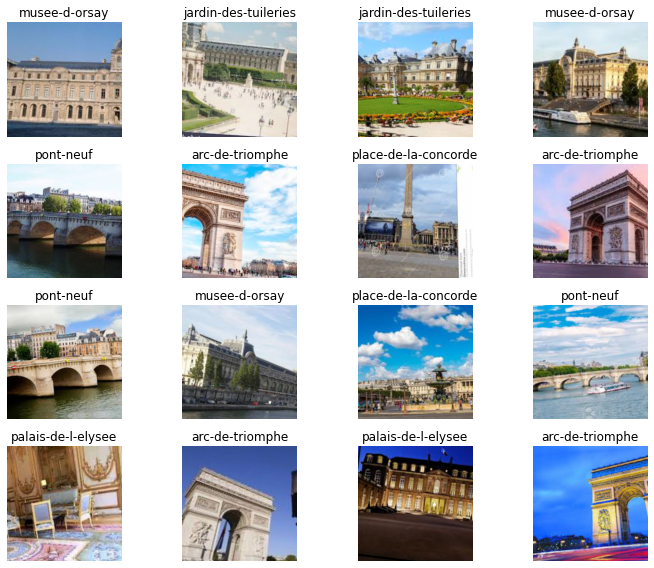

In [15]:
data.show_batch(4, figsize=(10,8))

In [16]:
print(data.classes)
len(data.classes), data.c

['arc-de-triomphe', 'hotel-de-ville', 'jardin-des-tuileries', 'moulin-rouge', 'musee-d-orsay', 'palais-de-l-elysee', 'place-de-la-concorde', 'pont-neuf']


(8, 8)

In [17]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


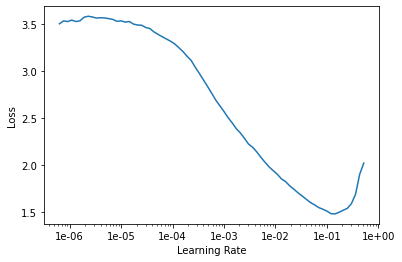

In [18]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.753431,0.181347,0.048450,0.951550,00:49
1,0.418368,0.205772,0.052326,0.947674,00:49
2,0.333031,0.169886,0.050388,0.949612,00:49
3,0.250226,0.129243,0.043605,0.956395,00:47
4,0.177637,0.106946,0.031977,0.968023,00:47
5,0.139563,0.113827,0.036822,0.963178,00:47
6,0.099932,0.095076,0.031008,0.968992,00:47
7,0.084928,0.090084,0.027132,0.972868,00:47
8,0.072367,0.089573,0.026163,0.973837,00:47
9,0.061060,0.091623,0.028101,0.971899,00:47


In [19]:
learn.save('monuments_model_stage1')

In [20]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.286291,1.257731,0.150194,0.849806,00:50
1,0.390306,0.908121,0.187016,0.812984,00:50
2,0.322969,0.112967,0.028101,0.971899,00:50
3,0.208636,0.075149,0.027132,0.972868,00:50
4,0.120421,0.063977,0.023256,0.976744,00:50


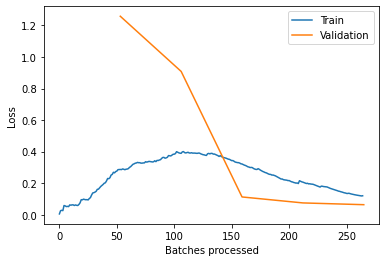

In [21]:
learn.recorder.plot_losses()

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

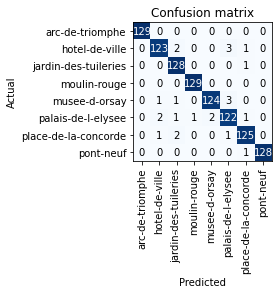

In [23]:
interp.plot_confusion_matrix()

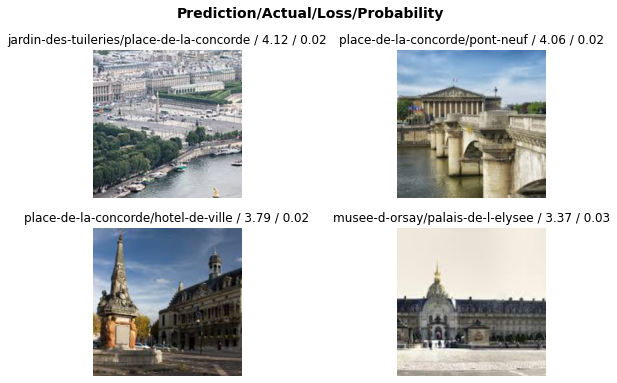

In [26]:
interp.plot_top_losses(4, figsize=(10,6))

In [27]:
learn.export()

In [28]:
TEST_PATH = DATA_PATH/'test'
TEST_FOLDER = ImageList.from_folder(TEST_PATH)

In [29]:
learn = load_learner(DATA_PATH, test=TEST_FOLDER)

In [30]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [31]:
data.classes

['arc-de-triomphe',
 'hotel-de-ville',
 'jardin-des-tuileries',
 'moulin-rouge',
 'musee-d-orsay',
 'palais-de-l-elysee',
 'place-de-la-concorde',
 'pont-neuf']

Path file: /content/temp/data/test/palais-de-l-elysee_imagesqtbn3AANd9GcShSG_yCe7QgSbBoygafBg8ENKjRJMmaJhATuHR6i5Rb6Tk4HusqpCAU.jpg
Predictions list: [tensor(3.3127e-06), tensor(0.0067), tensor(0.0001), tensor(2.5783e-06), tensor(3.8654e-05), tensor(0.9931), tensor(2.6387e-06), tensor(7.9859e-06)]
Prediction: palais-de-l-elysee
Accuracy: 0.993129312992096%


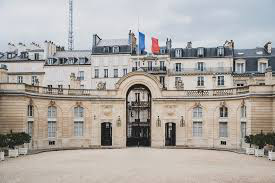

In [32]:
i = 25

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/temp/data/test/hotel-de-ville_imagesqtbn3AANd9GcQPPvv9a1LLU7HVg6zV174acUPQ9Xr9bxTtu78I2m2b5EHjjT8usqpCAU.jpg
Predictions list: [tensor(3.1084e-06), tensor(0.9985), tensor(9.7537e-06), tensor(1.0262e-06), tensor(0.0014), tensor(6.0565e-05), tensor(8.9983e-06), tensor(3.5107e-06)]
Prediction: hotel-de-ville
Accuracy: 0.9985349178314209%


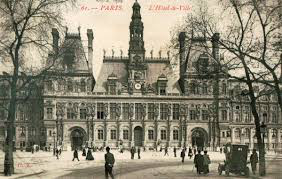

In [33]:
i = 125

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/temp/data/test/palais-de-l-elysee_imagesqtbn3AANd9GcSrGNEniEQ329EsxG4Ajy_3G3Uk8qMhdVSMCOyyoE70POEhGeOKusqpCAU.jpg
Predictions list: [tensor(0.0013), tensor(0.0579), tensor(0.0636), tensor(0.0009), tensor(0.1071), tensor(0.7662), tensor(0.0003), tensor(0.0027)]
Prediction: palais-de-l-elysee
Accuracy: 0.7662333250045776%


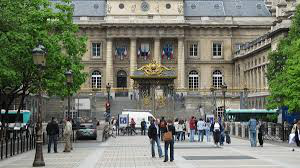

In [34]:
i = 225

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/temp/data/test/pont-neuf_imagesqtbn3AANd9GcRK3VMxeboJinlTqzA3kl8Iaxb0yeTvc48I8_dleTObihCJFGzusqpCAU.jpg
Predictions list: [tensor(1.0169e-08), tensor(6.6106e-08), tensor(1.4679e-07), tensor(7.8309e-08), tensor(6.1311e-07), tensor(3.2708e-09), tensor(3.0245e-06), tensor(1.0000)]
Prediction: pont-neuf
Accuracy: 0.9999960660934448%


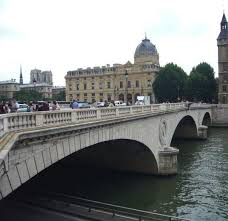

In [35]:
i = 325

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]

Path file: /content/temp/data/test/palais-de-l-elysee_imagesqtbn3AANd9GcTUwCYjpU6CPcSLrB5NUYs9D72LZvL9AnRR0xvWnDLo4rmbzpDiusqpCAU.jpg
Predictions list: [tensor(5.7306e-07), tensor(0.0086), tensor(0.0002), tensor(1.2076e-05), tensor(7.3039e-05), tensor(0.9911), tensor(2.7453e-06), tensor(9.4343e-06)]
Prediction: palais-de-l-elysee
Accuracy: 0.9911399483680725%


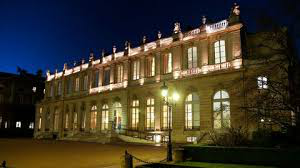

In [36]:
i = 399

print("Path file:", TEST_FOLDER.items[i])
print("Predictions list:", list(preds[i]))
print(f'Prediction: {data.classes[torch.argmax(preds[i])]}')
print(f'Accuracy: {preds[i][torch.argmax(preds[i])]}%')
TEST_FOLDER[i]